In [1]:
from contextualized_topic_models.models.ctm import ZeroShotTM, CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, get_bag_of_words
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import zipfile
import pickle
import nltk
import tqdm
import re
import numpy as np
import gensim
import os
import matplotlib.pyplot as plt

from nltk.corpus import stopwords as stop_words

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kreti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# The same one as in the test_environment.py
def progress_bar(iteration, total):
    total_len = 100
    percent_part = ("{0:.2f}").format(100 * (iteration / total))
    filled = int(total_len * iteration / total)
    bar = '█' * filled + '-' * (total_len - filled)
    print(f'\r Progress: [{bar}] {percent_part}%', end='')
    if iteration == total:
        print()

## Data preprocessing

In [3]:
def process_file(file, filename, texts):
    content = file.read(filename)
    if type(content) == bytes:
        text = content.decode('utf-8')
        sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
        for sentence in sentences:
            texts.append(sentence)

    if len(content.strip()) == 0:
        print("No text was found")
        return

In [4]:
texts = []
max_len = False
with zipfile.ZipFile("../data/articles_2021-11-05_1000.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-01-07_2000.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-02-04_500.zip", "r") as f:
# with zipfile.ZipFile("../data/articles_2023-02-09_1000.zip", "r") as f:
    total_f = len(f.namelist())
    counter = 1
    for filename in f.namelist():
        counter += 1
        process_file(f, filename, texts)
    f.close()

texts[:2]

['ISTANBUL, Oct 23 (Reuters) - Turkish President Tayyip Erdogan said on Saturday that he had told his foreign ministry to expel the ambassadors of the United States and nine other Western countries for demanding the release of philanthropist Osman Kavala.',
 "Seven of the ambassadors represent Turkey's NATO allies and the expulsions, if carried out, would open the deepest rift with the West in Erdogan's 19 years in power."]

In [5]:
stopwords = list(stop_words.words("english"))

# simple preprocessing that removes stopwords and punctuation
sp = WhiteSpacePreprocessingStopwords(texts, min_words=3, stopwords_list=stopwords)

# this function returns the pre and the unpre processed documents and a vocab with the most frequent 2K tokens
# these tokens are going to be used to represent the topics
preprocessed_documents, unpreprocessed_documents, vocab, retained_indices = sp.preprocess() 

In [6]:
preprocessed_documents[:2]

['oct reuters turkish president erdogan said saturday told foreign ministry ambassadors united states nine western countries demanding release kavala',
 'seven ambassadors turkey nato allies carried would open west erdogan years power']

In [7]:
tp = TopicModelDataPreparation("distiluse-base-multilingual-cased", max_seq_length=32) # instantiate a contextualized model

# create the training set
training_dataset = tp.fit(text_for_contextual=unpreprocessed_documents, text_for_bow=preprocessed_documents)

training_dataset

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\utils\data_preparation.py:64: UserWarning: the longest document in your collection has 137 words, the model instead truncates to 32 tokens.
  warnings.warn(


Batches:   0%|          | 0/76 [00:00<?, ?it/s]

In [8]:
word2id = {}
id2word = {}
for key, val in zip(vocab, retained_indices):
    word2id[key] = val
    id2word[val] = key

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Model training, saving, loading

In [9]:
# Not used yet in the experiment, WIP
def train_lda(num_topics):
    # Create the LDA model
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                id2word=id2word,
                                num_topics=num_topics,
                                workers=19,
                                random_state=100,
                                chunksize=100,
                                passes=10,
                                iterations=200,
                                alpha='symmetric',
                                per_word_topics=False
                                )
    return lda_model

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
def train_ntm_model(num_topics=5):
    ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=512, n_components=num_topics, num_epochs=5, batch_size=64)
    ctm.fit(training_dataset) # run the model
    ctm.save(models_dir='../models/ntm_topics' + str(num_topics) + '/')    
    return ctm

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Metrics and evaluation

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_tus(model, words_num, num_topics, is_lda):
    """
    Calculate Topic Uniqueness Score (TUS) for each topic in a given LDA model.
    Returns an array of TUS scores and a mean TUS score for a model.
    The lower TUS score means that topics are less similar <-> more unique.
    """
    words_num = model.bow_size
#     words_num = 100
    num_topics = model.n_components
    word_probs = np.zeros((num_topics, words_num))
    for topic_id in range(num_topics):
        if is_lda:
            word_probs[topic_id, :] = np.array([p for _, p in model.get_topic_terms(topic_id, words_num)])
        else:
            word_probs[topic_id, :] = np.array([p for _, p in model.get_word_distribution_by_topic_id(topic_id)])
    
    similarities = cosine_similarity(word_probs)
    np.fill_diagonal(similarities, 0) # set diagonal to 0 so a topic is not compared with itself
    tus_scores = np.mean(similarities, axis=1)
    tus_mean = np.mean(tus_scores)
    return tus_scores, tus_mean

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
from scipy.spatial import distance

def calc_hausdorff_distance(model, num_topics, is_lda):
    hd_matrix = np.zeros((num_topics, num_topics))  # initialize a matrix to store HD values
    
    for i in range(num_topics):
        for j in range(i+1, num_topics):
            # extract topic distributions for topics i and j
            if is_lda:
                topic_i_dist = model.get_topic_terms(i)
                topic_j_dist = model.get_topic_terms(j)
            else:
                # open-source ctm implementation does not limit number of words, so we have to limit it to the top-8 manually
                topic_i_dist = [[word2id[p]] for p, _ in model.get_word_distribution_by_topic_id(i)[:8]]
                topic_j_dist = [[word2id[p]] for p, _ in model.get_word_distribution_by_topic_id(j)[:8]]

            # compute asymmetric Hausdorff distance (HD) by saving the biggest of the two
            hd = max(distance.directed_hausdorff(topic_i_dist, topic_j_dist), 
                      distance.directed_hausdorff(topic_j_dist, topic_i_dist))

            hd_matrix[i, j] = hd[0]

    return np.mean(hd_matrix)

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
results = {'tus': {}, 'hd': {}}
corpuses = ["classic lda", "ntm"]
num_topics_arr = [5, 10, 15, 20]

def do_test():
    total_iter = len(corpuses) * len(num_topics_arr)
    curr_iter = 1
    for key in corpuses:
        results['tus'][key] = {}
        results['hd'][key] = {}
        for num_topics in num_topics_arr:
            progress_bar(curr_iter, total_iter)
            if key=='ntm':
                dir_path = f"../models/ntm_topics{num_topics}/"
                # if directory already exists, model have been saved before
                if os.path.isdir(f"../models/ntm_topics{num_topics}/"):
                    ctm_model = CombinedTM(bow_size=len(tp.vocab), contextual_size=512, n_components=num_topics, num_epochs=10, batch_size=64)
                    ctm_model.load(model_dir=dir_path, epoch=4)
                else:
                    ctm_model = train_ntm_model(num_topics)
                _, score_tus = calculate_tus(ctm_model, ctm_model.bow_size, ctm_model.n_components, False)
                score_hd = calc_hausdorff_distance(ctm_model, ctm_model.n_components, False)
            else:
#                 lda_model = train_lda(num_topics)
#                 _, score_tus = calculate_tus(lda_model)
#                 score_hd = calc_hausdorff_distance(lda_model)
                score_tus = 0
                score_hd = 0
            
            results['tus'][key][str(num_topics)] = score_tus
            results['hd'][key][str(num_topics)] = score_hd
            curr_iter += 1


do_test()

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(


 Progress: [███████████████████████████████████████████████████████████████████████████████████████-------------] 87.50%

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(


 Progress: [████████████████████████████████████████████████████████████████████████████████████████████████████] 100.00%


C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\contextualized_topic_models\models\ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(


In [31]:
results

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'tus': {'classic lda': {'5': 0, '10': 0, '15': 0, '20': 0},
  'ntm': {'5': 0.7996837151773741,
   '10': 0.8995028597509419,
   '15': 0.9328976683101744,
   '20': 0.9494619408702476}},
 'hd': {'classic lda': {'5': 0, '10': 0, '15': 0, '20': 0},
  'ntm': {'5': 136.64, '10': 135.72, '15': 165.92444444444445, '20': 157.455}}}

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


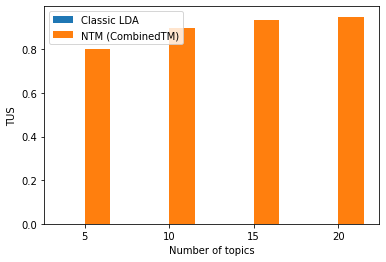

In [21]:
classic_keys = list(results['tus']['classic lda'].keys())
extended_keys = list(results['tus']['ntm'].keys())

classic_values = list(results['tus']['classic lda'].values())
extended_values = list(results['tus']['ntm'].values())

x_values = range(len(classic_keys))

bar_width = 0.3

# plot the bars for the classic dictionary values
plt.bar(x_values, classic_values, align='edge', width=-bar_width, alpha=1, label='Classic LDA')

# plot the bars for the new dictionary values
plt.bar(x_values, extended_values, align='edge', width=bar_width, alpha=1, label='NTM (CombinedTM)')

# set the x-axis ticks and labels
plt.xticks(x_values, classic_keys)

# add a legend to the plot
plt.legend()

Y_str = "TUS"

# set the y-axis label
plt.ylabel(Y_str)

# set the x-axis label
plt.xlabel('Number of topics')

# show the plot
plt.show()

C:\Programs\miniconda3\envs\NN_clone\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


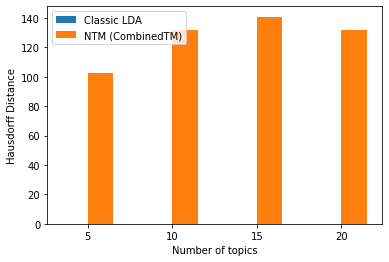

In [22]:
classic_keys = list(results['hd']['classic lda'].keys())
extended_keys = list(results['hd']['ntm'].keys())

classic_values = list(results['hd']['classic lda'].values())
extended_values = list(results['hd']['ntm'].values())

x_values = range(len(classic_keys))

bar_width = 0.3

# plot the bars for the classic dictionary values
plt.bar(x_values, classic_values, align='edge', width=-bar_width, alpha=1, label='Classic LDA')

# plot the bars for the new dictionary values
plt.bar(x_values, extended_values, align='edge', width=bar_width, alpha=1, label='NTM (CombinedTM)')

# set the x-axis ticks and labels
plt.xticks(x_values, classic_keys)

# add a legend to the plot
plt.legend()

Y_str = "Hausdorff Distance" 

# set the y-axis label
plt.ylabel(Y_str)

# set the x-axis label
plt.xlabel('Number of topics')

# show the plot
plt.show()